In [11]:
# from google.colab import drive
# drive.mount('/content/drive')

In [12]:
# Sentiment classifier using logistic regression and evaluation using precision, recall and F-measure
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score

inputPath = "/content/drive/MyDrive/AI2/ergasia_1/imdb-reviews.csv"


# The flag is used to signify the presence of a seperate test file
flag = 0

# Read the training csv file
df = pd.read_csv(inputPath, sep='\t')
test = 0


positive = 0
negative = 0
neutral = 0 

for index, row in df.iterrows():
    # if score is greater than 7, it is positive so change its value to 1, else -1
    if row["rating"] >= 7:
        positive += 1
        df.at[index, "rating"] = 1
    elif row["rating"] <= 4:
        negative += 1
        df.at[index, "rating"] = -1
    else:
        neutral += 1

# # ---- UNCOMMENT THIS TO ADD A TEST DATA SET ----

# # Read the test csv file
# test_inputPath = "test.csv"  # PUT YOUR TEST FILE NAME HERE
# test = pd.read_csv("test_inputPath", sep='\t')
# flag = 1


# for index, row in test.iterrows():
#     # if score is greater than 7, it is positive so change its value to 1, else -1
#     if row["rating"] >= 7:
#         positive += 1
#         test.at[index, "rating"] = 1
#     elif row["rating"] <= 4:
#         negative += 1
#         test.at[index, "rating"] = -1
#     else:
#         neutral += 1
# # -----------------------------------------------

print("Positive: ", positive)
print("Negative: ", negative)
print("Neutral: ", neutral)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df["review"], df["rating"], test_size=0.2, random_state=42)

# If flag is 1, then we are using the test data for X_test and y_test
if flag == 1:
    X_test = test["review"]
    y_test = test["rating"]
    print("Testing on the test data")




# Use CountVectorizer to vectorize the text data
count_vectorizer = CountVectorizer(stop_words="english", binary=False)
count_train = count_vectorizer.fit_transform(X_train.values)
count_test = count_vectorizer.transform(X_test.values)


# # Use HashingVectorizer instead of CountVectorizer
# from sklearn.feature_extraction.text import HashingVectorizer
# hashing_vectorizer = HashingVectorizer(stop_words="english", binary=False)
# count_train = hashing_vectorizer.fit_transform(X_train.values)
# count_test = hashing_vectorizer.transform(X_test.values)


Positive:  22508
Negative:  22500
Neutral:  0


In [13]:
# Use grid search to find the best hyperparameters for the model (C, penalty, max_iter, solver, multi_class, class_weight)
from sklearn.model_selection import GridSearchCV

# Create the parameter grid based on the results of random search
param_grid = {
    'C': [0.1, 0.5, 1, 2],
    'penalty': ['l2', 'l1'],
    'max_iter': [500],
    'solver': ['lbfgs', 'liblinear'],
    'multi_class': ['auto', 'ovr'],
    'class_weight': ['balanced', None]
}

# Create the model
classifier = LogisticRegression()

# Create the grid search
grid_search = GridSearchCV(estimator = classifier, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2, scoring="f1_macro")

# Fit the grid search to the data
grid_search.fit(count_train, y_train)

Fitting 3 folds for each of 64 candidates, totalling 192 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
48 fits failed out of a total of 192.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
48 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 449, in _check_solver
    % (solver, penalty)
ValueError: Solve

GridSearchCV(cv=3, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.1, 0.5, 1, 2],
                         'class_weight': ['balanced', None], 'max_iter': [500],
                         'multi_class': ['auto', 'ovr'],
                         'penalty': ['l2', 'l1'],
                         'solver': ['lbfgs', 'liblinear']},
             scoring='f1_macro', verbose=2)

In [14]:
print(grid_search.best_params_)

{'C': 0.1, 'class_weight': None, 'max_iter': 500, 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'liblinear'}


Precision:  0.893929775998715
Recall:  0.8939736678415924
F-measure:  0.8939106716529297


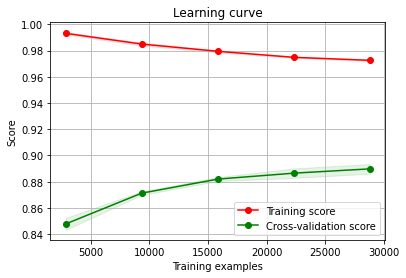

In [15]:
# Train the model with the best hyperparameters

# Best Paramaeters for CountVectorizer
classifier = LogisticRegression(max_iter=500, penalty = 'l2', C =0.1, solver='liblinear', multi_class='auto', class_weight=None)

# Best Parameters for HashingVectorizer
# classifier = LogisticRegression(max_iter=500, penalty = 'l2', C = 2, solver='lbfgs', multi_class='auto', class_weight='balanced')

# Train the model
classifier.fit(count_train, y_train)

# Predict the sentiment
y_pred = classifier.predict(count_test)

# Evaluate the model
print("Precision: ", precision_score(y_test, y_pred, average="macro"))
print("Recall: ", recall_score(y_test, y_pred, average="macro"))
print("F-measure: ", f1_score(y_test, y_pred, average="macro"))

# plot the learning curve of the model to see if it is overfitting or underfitting
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

train_sizes, train_scores, test_scores = learning_curve(classifier, count_train, y_train, cv=5, scoring="f1_macro", n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 5))

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)


plt.title("Learning curve")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.grid()

 # Training score
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
 # Cross-validation score
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")

plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

plt.legend(loc="best")
plt.show()
